In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/COURSES/CS231/train_split.txt', sep=" ", header=None)
train_df.columns = ['patient id', 'file_paths', 'labels', 'data source']
train_df = train_df.drop(['patient id', 'data source'], axis=1)

In [ ]:
train_df.head()

,file_paths,labels
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/COURSES/CS231/test_split.txt', sep=" ", header=None)
test_df.columns = ['patient id', 'file_paths', 'labels', 'data source']
test_df = test_df.drop(['patient id', 'data source'], axis=1)

In [ ]:
test_df.head()

,file_paths,labels
0,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia
1,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
2,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
3,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
4,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/COURSES/CS231/data/train"
TEST_PATH = "/content/drive/MyDrive/COURSES/CS231/data/test"

# Balancing Classes

In [ ]:
train_df['labels'].value_counts()

normal       8751
pneumonia    5963
COVID-19     4649
Name: labels, dtype: int64

In [ ]:
file_count = 4649
samples = []
for category in train_df['labels'].unique():
    category_slice = train_df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False, random_state=1))
train_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(train_df['labels'].value_counts())
print(len(train_df))

normal       4649
COVID-19     4649
pneumonia    4649
Name: labels, dtype: int64
13947


# Spliting train_df into train_df and valid_df

In [ ]:
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

In [ ]:
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

COVID-19     4213
normal       4189
pneumonia    4150
Name: labels, dtype: int64
pneumonia    499
normal       460
COVID-19     436
Name: labels, dtype: int64
COVID-19     274
pneumonia    105
normal       100
Name: labels, dtype: int64


# Image Data Generators

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
target_size = (img_height, img_width)

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input, 
                                   horizontal_flip=True, zoom_range=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df, directory=TRAIN_PATH, x_col='file_paths', y_col='labels',
                                                    target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(valid_df, directory=TRAIN_PATH, x_col='file_paths', y_col='labels',
                                                    target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(test_df, directory=TEST_PATH, x_col='file_paths', y_col='labels',
                                                    target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical', shuffle = False)

Found 12552 validated image filenames belonging to 3 classes.
Found 1395 validated image filenames belonging to 3 classes.
Found 479 validated image filenames belonging to 3 classes.


# Create Model

In [ ]:
base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))

for layer in base_model.layers[:190]:
    layer.trainable = False

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 pool1_pad - False
4 pool1_pool - False
5 conv2_block1_preact_bn - False
6 conv2_block1_preact_relu - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_pad - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_out - False
17 conv2_block2_preact_bn - False
18 conv2_block2_preact_relu - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_pad - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_out - False
28 conv2_block3_preact_bn - False
29 conv2_block3_preact_relu - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_pad - False
3

In [ ]:
model = tf.keras.Sequential([
    base_model,
    # GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax'),
])

In [ ]:
lr = 5e-4
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

# Callbacks

In [ ]:
patience = 5
stop_patience = 3
factor = 0.1
callbacks = [
    ModelCheckpoint("resnet50v2-3.h5", save_best_only=True, verbose = 0),
    EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, min_lr=1e-6, verbose=1)
]

# Model Training

In [ ]:
epochs = 50
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/30
393/393 [==============================] - 303s 767ms/step - loss: 0.8399 - accuracy: 0.6519 - val_loss: 0.4524 - val_accuracy: 0.8358


/Users/ngctnnnn/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
393/393 [==============================] - 303s 770ms/step - loss: 0.5290 - accuracy: 0.8007 - val_loss: 0.4100 - val_accuracy: 0.8437
Epoch 3/30
393/393 [==============================] - 303s 769ms/step - loss: 0.4260 - accuracy: 0.8459 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 4/30
393/393 [==============================] - 306s 778ms/step - loss: 0.3859 - accuracy: 0.8587 - val_loss: 0.3775 - val_accuracy: 0.8659
Epoch 5/30
393/393 [==============================] - 304s 772ms/step - loss: 0.3566 - accuracy: 0.8708 - val_loss: 0.3786 - val_accuracy: 0.8602
Epoch 6/30
393/393 [==============================] - 305s 775ms/step - loss: 0.3277 - accuracy: 0.8834 - val_loss: 0.3814 - val_accuracy: 0.8717
Epoch 7/30
393/393 [==============================] - 310s 787ms/step - loss: 0.3181 - accuracy: 0.8832 - val_loss: 0.3806 - val_accuracy: 0.8631

Epoch 00007: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 8/30
393/393 [======================

In [ ]:
train_loss = [0.8399, 0.5290, 0.4260, 0.3859, 0.3566, 0.3277, 0.3181, 0.2832, 0.2755, 0.2660, 0.2666, 0.2558, 0.2458, 0.2550]
train_acc = [0.6519, 0.8007, 0.8459, 0.8587, 0.8708, 0.8834, 0.8832, 0.9042, 0.9050, 0.9075, 0.9058, 0.9120, 0.9146, 0.9123]
val_loss = [0.4524, 0.4100, 0.3961, 0.3775, 0.3786, 0.3814, 0.3806, 0.3669, 0.3576, 0.3622, 0.3686, 0.3640, 0.3650, 0.3683]
val_acc = [0.8358, 0.8437, 0.8566, 0.8659, 0.8602, 0.8717, 0.8631, 0.8631, 0.8652, 0.8674, 0.8695, 0.8688, 0.8688, 0.8652]

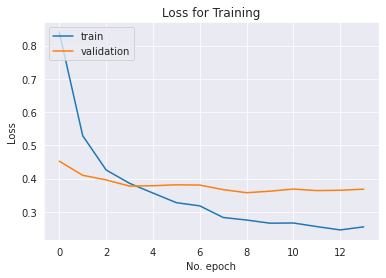

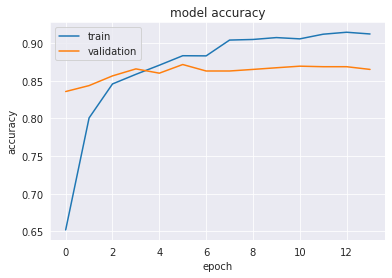

In [ ]:
plt.plot(train_loss, label='Loss (training data)')
plt.plot(val_loss, label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.savefig ('/content/drive/MyDrive/COURSES/CS231/results/resnet50_14-1')
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig ('/content/drive/MyDrive/COURSES/CS231/results/resnet50_14-2')
plt.show()

# Predictions on Test Set

In [ ]:
best_model = model
best_model.load_weights('/content/drive/MyDrive/COURSES/CS231/resnet50v2-3.h5')

In [ ]:
best_model.evaluate(test_generator)

15/15 [==============================] - 28s 2s/step - loss: 0.6630 - accuracy: 0.7704


[0.662989616394043, 0.7703549265861511]

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]

    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir, dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      

    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    

    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
            
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig1=plt.figure()
        fig1.set_figheight(len(plot_class)/3)
        fig1.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        fig2 = plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/resnet50_14-4.png", dpi = 100)
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

        fig1.savefig("/content/drive/MyDrive/COURSES/CS231/results/resnet50_14-3.png", dpi = 100)

In [ ]:
preds = best_model.predict(test_generator)

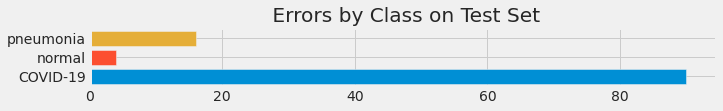

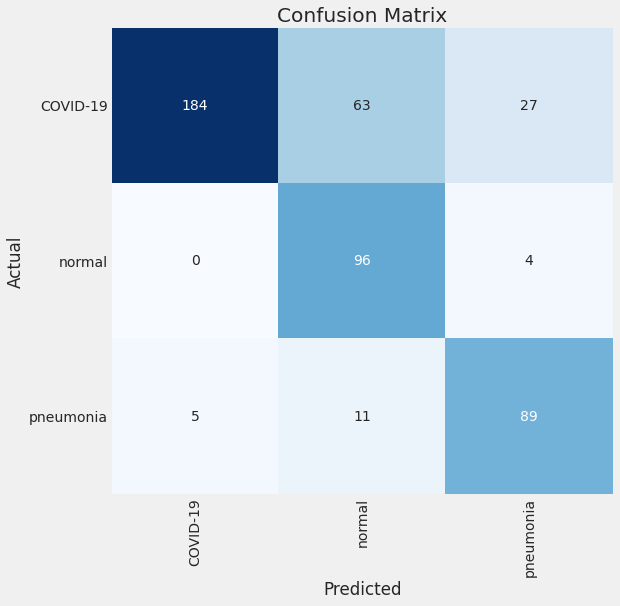

Classification Report:
----------------------
               precision    recall  f1-score   support

    COVID-19       0.97      0.67      0.79       274
      normal       0.56      0.96      0.71       100
   pneumonia       0.74      0.85      0.79       105

    accuracy                           0.77       479
   macro avg       0.76      0.83      0.77       479
weighted avg       0.84      0.77      0.78       479



In [ ]:
save_dir = '/content/drive/MyDrive/COURSES/CS231'
subject = "kq"
print_code = 0
print_info(test_generator, preds, print_code, save_dir, subject)